### Importing Libraries

In [49]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import NearMiss
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pickle
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Reading the input data

In [50]:
drought_df = pd.read_csv('validation_timeseries.csv')
drought_df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2017-01-01,32.50,100.02,10.47,14.69,14.47,14.47,17.68,10.53,...,14.63,2.14,2.71,1.52,1.19,4.40,5.96,2.25,3.71,NaN
1,1001,2017-01-02,63.52,100.04,12.75,17.96,17.75,17.75,20.30,16.14,...,17.85,2.75,4.31,1.60,2.71,5.50,8.16,4.05,4.11,NaN
2,1001,2017-01-03,18.82,99.69,9.74,14.24,13.44,13.44,18.48,9.29,...,14.06,2.25,3.73,1.64,2.09,4.80,7.27,2.54,4.72,2.0
3,1001,2017-01-04,0.01,100.02,5.21,8.10,3.86,3.88,11.74,2.12,...,8.08,2.63,3.95,1.34,2.60,4.98,6.16,3.36,2.80,NaN
4,1001,2017-01-05,0.01,99.89,4.54,5.91,2.20,2.22,13.07,-0.18,...,5.85,1.76,2.76,0.47,2.28,3.43,4.70,0.66,4.04,NaN


In [51]:
print(drought_df.columns)

Index(['fips', 'date', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET',
       'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX',
       'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN',
       'WS50M_RANGE', 'score'],
      dtype='object')


### Initial exploration and data cleaning 


In [52]:
drought_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2268840 entries, 0 to 2268839
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 363.5+ MB


In [53]:
drought_df.isnull().sum()

fips                 0
date                 0
PRECTOT              0
PS                   0
QV2M                 0
T2M                  0
T2MDEW               0
T2MWET               0
T2M_MAX              0
T2M_MIN              0
T2M_RANGE            0
TS                   0
WS10M                0
WS10M_MAX            0
WS10M_MIN            0
WS10M_RANGE          0
WS50M                0
WS50M_MAX            0
WS50M_MIN            0
WS50M_RANGE          0
score          1945608
dtype: int64

In [54]:
isna = drought_df.isna().sum().reset_index(name="missing_values")
isna['percentage'] = round((isna['missing_values'] / drought_df.shape[0]) * 100, 2)

# Sort the 'isna' DataFrame by the 'missing_values' column in descending order and display the top 35 rows
isna.sort_values(by='missing_values', ascending=False)

,index,missing_values,percentage
20,score,1945608,85.75
11,TS,0,0.00
19,WS50M_RANGE,0,0.00
18,WS50M_MIN,0,0.00
17,WS50M_MAX,0,0.00
16,WS50M,0,0.00
15,WS10M_RANGE,0,0.00
14,WS10M_MIN,0,0.00
13,WS10M_MAX,0,0.00
12,WS10M,0,0.00


#### <font color='darkblue'>Missing value Treatment

In [55]:
# Removing the null values in the target variable as the drought score is only available for once in 7 days.
drought_df = drought_df.dropna()
drought_df.isnull().sum()

fips           0
date           0
PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
dtype: int64

#### <font color='darkblue'>Reformatting the data

In [56]:
drought_df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score          float64
dtype: object

In [57]:
drought_df['year'] = pd.DatetimeIndex(drought_df['date']).year
drought_df['month'] = pd.DatetimeIndex(drought_df['date']).month
drought_df['day'] = pd.DatetimeIndex(drought_df['date']).day
drought_df['score'] = drought_df['score'].round().astype(int)
drought_df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score            int32
year             int32
month            int32
day              int32
dtype: object

In [58]:
drought_df['fips'].nunique()

3108

In [59]:
drought_df['score'].round().value_counts()

score
0    220516
1     56389
2     28498
3     12334
4      4577
5       918
Name: count, dtype: int64

In [60]:
drought_df=drought_df.drop('date',axis=1)
drought_df.head()

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,year,month,day
2,1001,18.82,99.69,9.74,14.24,13.44,13.44,18.48,9.29,9.20,...,1.64,2.09,4.80,7.27,2.54,4.72,2,2017,1,3
9,1001,0.02,101.13,5.62,5.92,4.54,4.55,12.42,-2.37,14.79,...,2.52,1.72,6.19,7.55,4.68,2.86,2,2017,1,10
16,1001,0.14,100.60,11.41,17.21,16.06,16.06,23.03,13.15,9.88,...,1.71,1.90,4.93,5.90,2.76,3.15,2,2017,1,17
23,1001,0.00,99.72,5.60,9.27,5.34,5.35,16.23,4.18,12.06,...,1.03,1.31,3.52,6.49,1.47,5.02,1,2017,1,24
30,1001,0.00,100.37,7.31,11.38,9.21,9.21,20.29,5.05,15.24,...,1.76,1.24,5.00,7.40,2.88,4.52,1,2017,1,31


### **Exploraory Data Analysis**

In [61]:
# Descriptive statistics
display(drought_df.describe()) # For numeric columns
print("\nSkewness: \n", drought_df.skew(axis = 0, skipna = True))
print("\nKurtosis: \n", drought_df.kurtosis(axis = 0, skipna = True))

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,year,month,day
count,323232.000000,323232.000000,323232.000000,323232.000000,323232.000000,323232.000000,323232.000000,323232.000000,323232.000000,323232.000000,...,323232.000000,323232.000000,323232.000000,323232.000000,323232.000000,323232.000000,323232.000000,323232.000000,323232.000000,323232.000000
mean,30670.376770,2.927214,96.684440,8.333459,13.295507,7.854001,7.868833,18.958342,8.085257,10.873111,...,1.901412,3.245704,5.482770,7.743991,3.103669,4.640333,0.536101,2017.500000,6.451923,15.971154
std,14979.130559,6.586135,5.425649,4.934976,10.869815,10.534395,10.381420,11.399701,10.645347,3.887730,...,1.349835,1.943274,2.354709,2.908380,2.120535,2.175164,0.938458,0.500001,3.447077,8.753537
min,1001.000000,0.000000,67.090000,0.250000,-29.180000,-29.820000,-29.490000,-23.010000,-32.840000,0.160000,...,0.000000,0.220000,0.660000,1.200000,0.010000,0.480000,0.000000,2017.000000,1.000000,1.000000
25%,19044.500000,0.000000,95.900000,3.970000,4.930000,-0.200000,-0.230000,10.660000,-0.220000,8.110000,...,0.940000,1.790000,3.740000,5.600000,1.420000,3.090000,0.000000,2017.000000,3.750000,8.750000
50%,29212.000000,0.210000,98.290000,7.510000,14.820000,9.020000,8.930000,21.020000,8.960000,10.810000,...,1.640000,2.780000,5.090000,7.270000,2.770000,4.210000,0.000000,2017.500000,6.500000,16.000000
75%,46007.500000,2.590000,99.960000,12.370000,22.660000,16.960000,16.900000,28.150000,17.230000,13.510000,...,2.560000,4.230000,6.850000,9.430000,4.370000,5.740000,1.000000,2018.000000,9.250000,24.000000
max,56043.000000,178.540000,104.010000,20.800000,40.270000,25.960000,25.960000,50.030000,32.150000,30.230000,...,16.000000,18.160000,21.780000,26.680000,19.490000,21.240000,5.000000,2018.000000,12.000000,31.000000



Skewness: 
 fips          -0.077368
PRECTOT        4.696459
PS            -2.136181
QV2M           0.393559
T2M           -0.471540
T2MDEW        -0.411979
T2MWET        -0.359255
T2M_MAX       -0.522371
T2M_MIN       -0.389659
T2M_RANGE      0.151965
TS            -0.440709
WS10M          1.178434
WS10M_MAX      1.010529
WS10M_MIN      1.525542
WS10M_RANGE    1.356531
WS50M          0.918241
WS50M_MAX      0.989036
WS50M_MIN      0.910764
WS50M_RANGE    1.302663
score          1.936850
year           0.000000
month         -0.016903
day            0.009069
dtype: float64

Kurtosis: 
 fips           -1.100134
PRECTOT        37.994212
PS              4.844448
QV2M           -1.039084
T2M            -0.585600
T2MDEW         -0.658338
T2MWET         -0.777382
T2M_MAX        -0.497585
T2M_MIN        -0.547148
T2M_RANGE      -0.214139
TS             -0.583237
WS10M           1.945595
WS10M_MAX       1.141111
WS10M_MIN       4.549398
WS10M_RANGE     2.472745
WS50M           1.195245
WS50M_M

#### Skewness is in the range of good values (-2 to +2) for all columns except PRECTOT and PS
#### Kurtosis is in the range of good values (-7 to+7) for all columns except for PS column


In [62]:
column_list = list(drought_df.columns)
column_list

['fips',
 'PRECTOT',
 'PS',
 'QV2M',
 'T2M',
 'T2MDEW',
 'T2MWET',
 'T2M_MAX',
 'T2M_MIN',
 'T2M_RANGE',
 'TS',
 'WS10M',
 'WS10M_MAX',
 'WS10M_MIN',
 'WS10M_RANGE',
 'WS50M',
 'WS50M_MAX',
 'WS50M_MIN',
 'WS50M_RANGE',
 'score',
 'year',
 'month',
 'day']

In [63]:
measures_column_list = ['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']
drought_df_measures = drought_df[['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']]

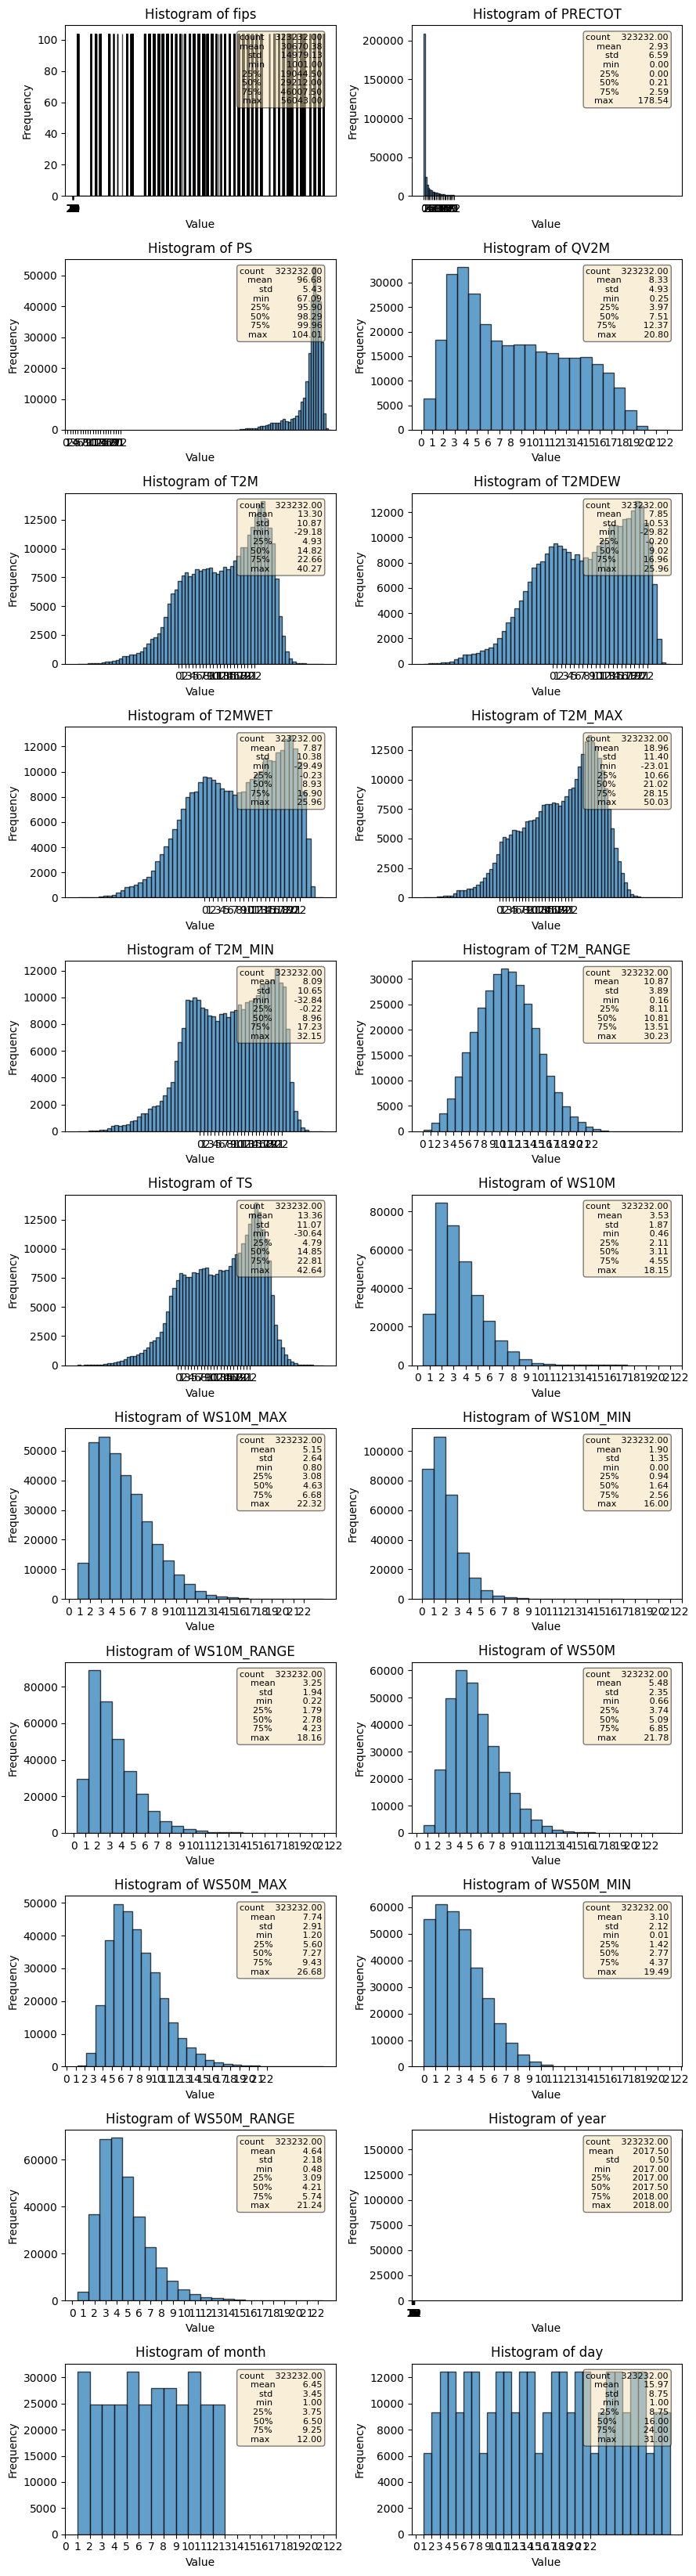

In [64]:
columns = drought_df.drop('score', axis=1).columns
n_cols = 2
n_rows = int(np.ceil(len(columns) / n_cols))

# Create subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(9, n_rows * 3))
axes = axes.flatten()

# Plot histograms for each column except 'score'
for i, column in enumerate(columns):
    ax = axes[i]
    col_data = drought_df[column]
    ax.hist(col_data, bins=np.arange(col_data.min(), col_data.max() + 2), edgecolor='k', alpha=0.7)
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.set_xticks(np.arange(0, 23, 1))  # Set x-ticks from 0 to 22

    # Summary statistics text
    summary_text = col_data.describe().apply(lambda x: f'{x:.2f}').to_string()
    ax.text(0.95, 0.95, summary_text, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Remove any unused subplots
for ax in axes[len(columns):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

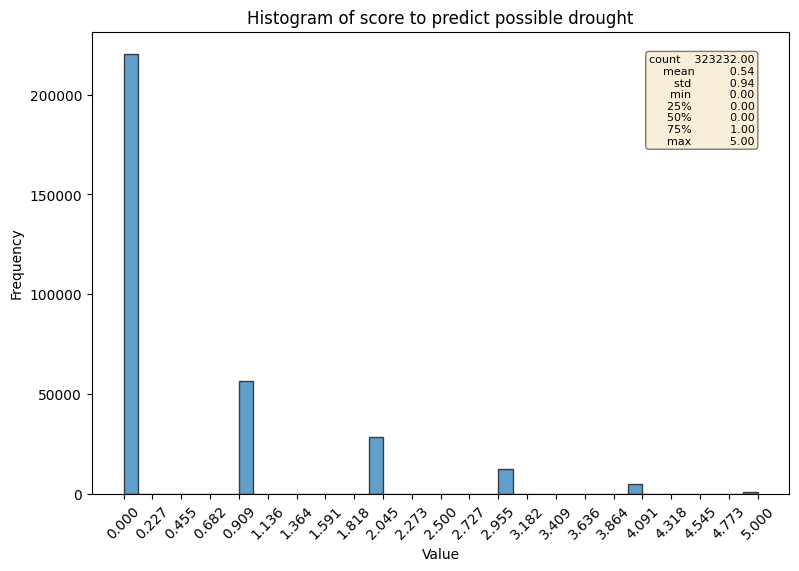

In [65]:
fig, ax = plt.subplots(figsize=(9, 6))
bins = np.linspace(drought_df['score'].min(), drought_df['score'].max(), 45) # min, max, bar count

# Plot FloodProbability
ax.hist(drought_df['score'], bins=bins, alpha=0.7, edgecolor='k')
ax.set_title(f'Histogram of score to predict possible drought')
ax.set_xlabel('Value')
ax.set_ylabel('Frequency')
ax.set_xticks(bins[::2])
ax.tick_params(axis='x', rotation=45)

# Summary statistics text
summary_text = drought_df['score'].describe().apply(lambda x: f'{x:.2f}').to_string()
ax.text(0.95, 0.95, summary_text, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.show()

## Outlier Treatment

#### Identifying Outliers

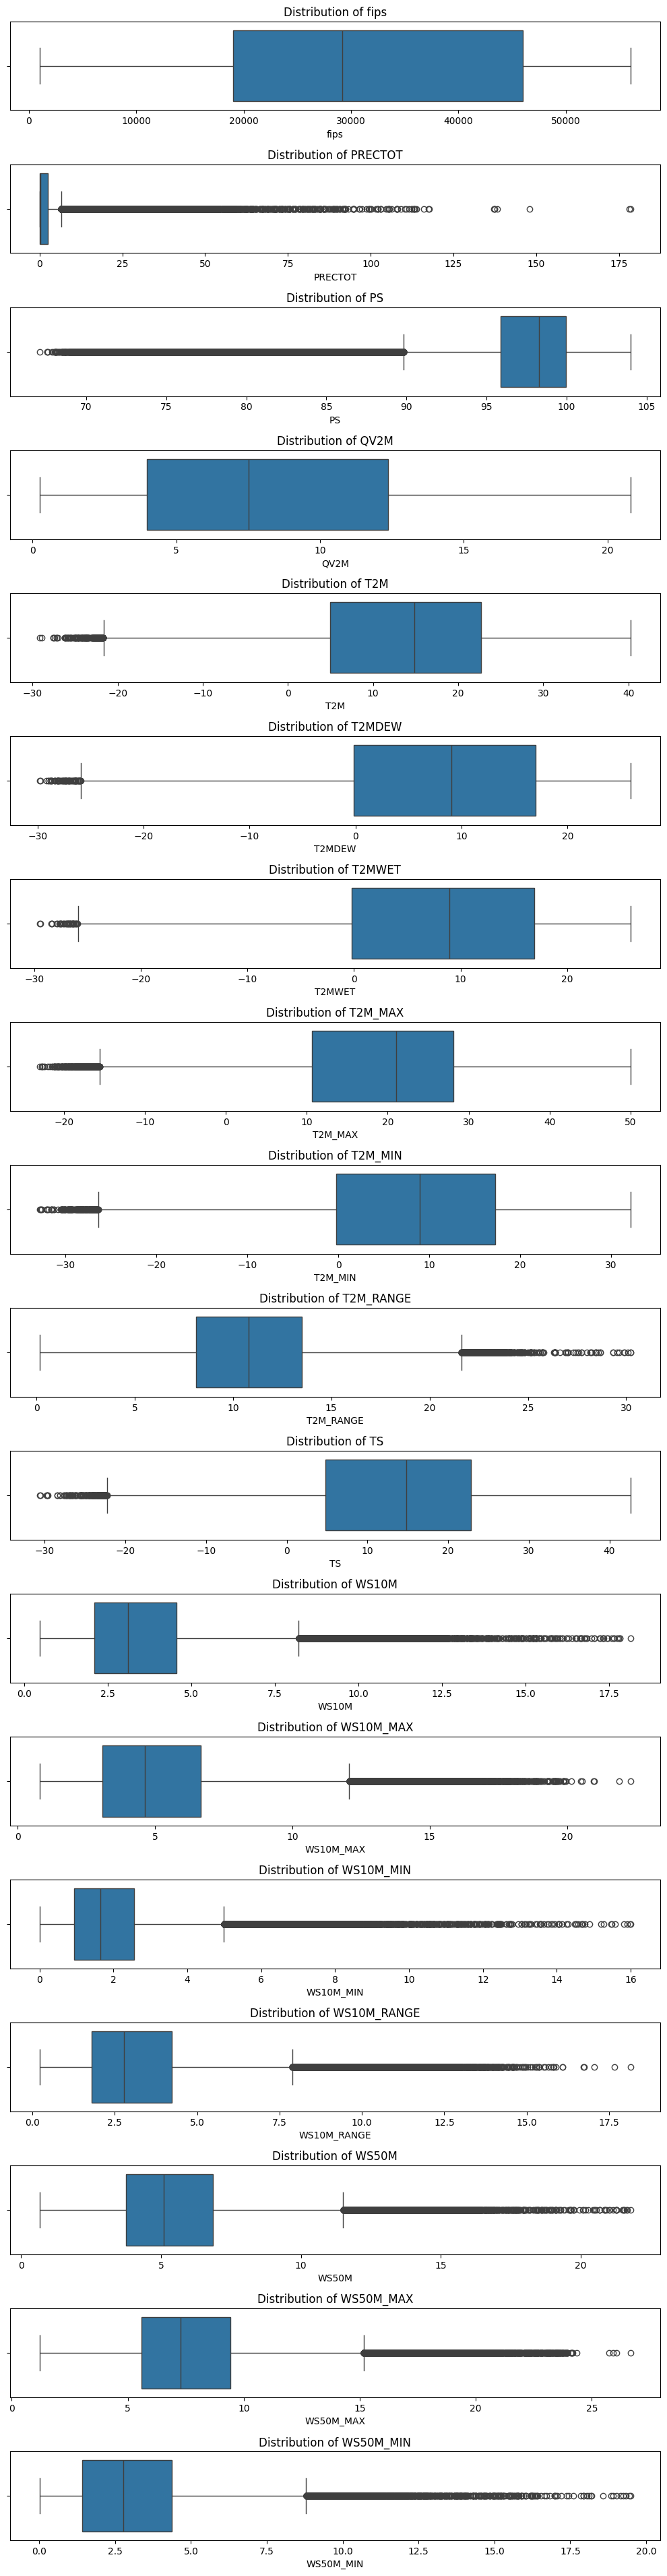

In [66]:
import seaborn as sns
plt.figure(figsize=(10,40))
for x in (range(1,19)):
    plt.subplot(19,1,x)
    sns.boxplot(x =  drought_df.columns[x-1], data=drought_df)
    x_name = drought_df.columns[x-1]
    plt.title(f'Distribution of {x_name}')         
plt.tight_layout()

####  Identifying outliers with the lower limit set as mean-3*std and upper limit set as mean+3*std

In [67]:
print('Total rows = ',len(drought_df.index))
for i in drought_df.select_dtypes(exclude = ['object']).columns:
    print ('Number of values beyong standard outlier limit in ', i)
    print(len(drought_df[(drought_df[i] > drought_df[i].mean() + 3*drought_df[i].std()) | (drought_df[i] < drought_df[i].mean() - 3*drought_df[i].std())]))

Total rows =  323232
Number of values beyong standard outlier limit in  fips
0
Number of values beyong standard outlier limit in  PRECTOT
7411
Number of values beyong standard outlier limit in  PS
8586
Number of values beyong standard outlier limit in  QV2M
0
Number of values beyong standard outlier limit in  T2M
584
Number of values beyong standard outlier limit in  T2MDEW
283
Number of values beyong standard outlier limit in  T2MWET
182
Number of values beyong standard outlier limit in  T2M_MAX
468
Number of values beyong standard outlier limit in  T2M_MIN
620
Number of values beyong standard outlier limit in  T2M_RANGE
428
Number of values beyong standard outlier limit in  TS
570
Number of values beyong standard outlier limit in  WS10M
3134
Number of values beyong standard outlier limit in  WS10M_MAX
3086
Number of values beyong standard outlier limit in  WS10M_MIN
4279
Number of values beyong standard outlier limit in  WS10M_RANGE
4454
Number of values beyong standard outlier limit

#### Removing values beyond the standard outlier limit

In [68]:
drought_df = drought_df[(drought_df['PRECTOT'] <= drought_df['PRECTOT'].mean() + 3*drought_df['PRECTOT'].std()) &
        (drought_df['PRECTOT'] >= drought_df['PRECTOT'].mean() - 3*drought_df['PRECTOT'].std())]

drought_df = drought_df[(drought_df['PS'] <= drought_df['PS'].mean() + 3*drought_df['PS'].std()) &
        (drought_df['PS'] >= drought_df['PS'].mean() - 3*drought_df['PS'].std())]

drought_df = drought_df[(drought_df['QV2M'] <= drought_df['QV2M'].mean() + 3*drought_df['QV2M'].std()) &
        (drought_df['QV2M'] >= drought_df['QV2M'].mean() - 3*drought_df['QV2M'].std())]

drought_df = drought_df[(drought_df['T2M'] <= drought_df['T2M'].mean() + 3*drought_df['T2M'].std()) &
        (drought_df['T2M'] >= drought_df['T2M'].mean() - 3*drought_df['T2M'].std())]

drought_df = drought_df[(drought_df['T2MDEW'] <= drought_df['T2MDEW'].mean() + 3*drought_df['T2MDEW'].std()) &
        (drought_df['T2MDEW'] >= drought_df['T2MDEW'].mean() - 3*drought_df['T2MDEW'].std())]

drought_df = drought_df[(drought_df['T2MWET'] <= drought_df['T2MWET'].mean() + 3*drought_df['T2MWET'].std()) &
        (drought_df['T2MWET'] >= drought_df['T2MWET'].mean() - 3*drought_df['T2MWET'].std())]

drought_df = drought_df[(drought_df['T2M_MAX'] <= drought_df['T2M_MAX'].mean() + 3*drought_df['T2M_MAX'].std()) &
        (drought_df['T2M_MAX'] >= drought_df['T2M_MAX'].mean() - 3*drought_df['T2M_MAX'].std())]

drought_df = drought_df[(drought_df['T2M_MIN'] <= drought_df['T2M_MIN'].mean() + 3*drought_df['T2M_MIN'].std()) &
        (drought_df['T2M_MIN'] >= drought_df['T2M_MIN'].mean() - 3*drought_df['T2M_MIN'].std())]

drought_df = drought_df[(drought_df['T2M_RANGE'] <= drought_df['T2M_RANGE'].mean() + 3*drought_df['T2M_RANGE'].std()) &
        (drought_df['T2M_RANGE'] >= drought_df['T2M_RANGE'].mean() - 3*drought_df['T2M_RANGE'].std())]

drought_df = drought_df[(drought_df['TS'] <= drought_df['TS'].mean() + 3*drought_df['TS'].std()) &
        (drought_df['TS'] >= drought_df['TS'].mean() - 3*drought_df['TS'].std())]

drought_df = drought_df[(drought_df['WS10M'] <= drought_df['WS10M'].mean() + 3*drought_df['WS10M'].std()) &
        (drought_df['WS10M'] >= drought_df['WS10M'].mean() - 3*drought_df['WS10M'].std())]

drought_df = drought_df[(drought_df['WS10M_MAX'] <= drought_df['WS10M_MAX'].mean() + 3*drought_df['WS10M_MAX'].std()) &
        (drought_df['WS10M_MAX'] >= drought_df['WS10M_MAX'].mean() - 3*drought_df['WS10M_MAX'].std())]

drought_df = drought_df[(drought_df['WS10M_MIN'] <= drought_df['WS10M_MIN'].mean() + 3*drought_df['WS10M_MIN'].std()) &
        (drought_df['WS10M_MIN'] >= drought_df['WS10M_MIN'].mean() - 3*drought_df['WS10M_MIN'].std())]

drought_df = drought_df[(drought_df['WS10M_RANGE'] <= drought_df['WS10M_RANGE'].mean() + 3*drought_df['WS10M_RANGE'].std()) &
        (drought_df['WS10M_RANGE'] >= drought_df['WS10M_RANGE'].mean() - 3*drought_df['WS10M_RANGE'].std())]

drought_df = drought_df[(drought_df['WS50M'] <= drought_df['WS50M'].mean() + 3*drought_df['WS50M'].std()) &
        (drought_df['WS50M'] >= drought_df['WS50M'].mean() - 3*drought_df['WS50M'].std())]

drought_df = drought_df[(drought_df['WS50M_MAX'] <= drought_df['WS50M_MAX'].mean() + 3*drought_df['WS50M_MAX'].std()) &
        (drought_df['WS50M_MAX'] >= drought_df['WS50M_MAX'].mean() - 3*drought_df['WS50M_MAX'].std())]

drought_df = drought_df[(drought_df['WS50M_MIN'] <= drought_df['WS50M_MIN'].mean() + 3*drought_df['WS50M_MIN'].std()) &
        (drought_df['WS50M_MIN'] >= drought_df['WS50M_MIN'].mean() - 3*drought_df['WS50M_MIN'].std())]

drought_df = drought_df[(drought_df['WS50M_RANGE'] <= drought_df['WS50M_RANGE'].mean() + 3*drought_df['WS50M_RANGE'].std()) &
        (drought_df['WS50M_RANGE'] >= drought_df['WS50M_RANGE'].mean() - 3*drought_df['WS50M_RANGE'].std())]

print('Total rows = ',len(drought_df.index))

Total rows =  290258


#### Distribution of categorical variables

In [69]:
categorical_column_list = ['score','year','month','day']
drought_df_categorical = drought_df[['score','year','month','day']]

<Figure size 1000x4000 with 0 Axes>

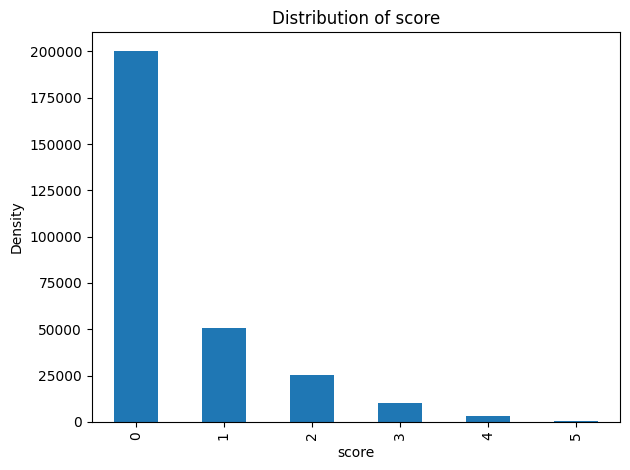

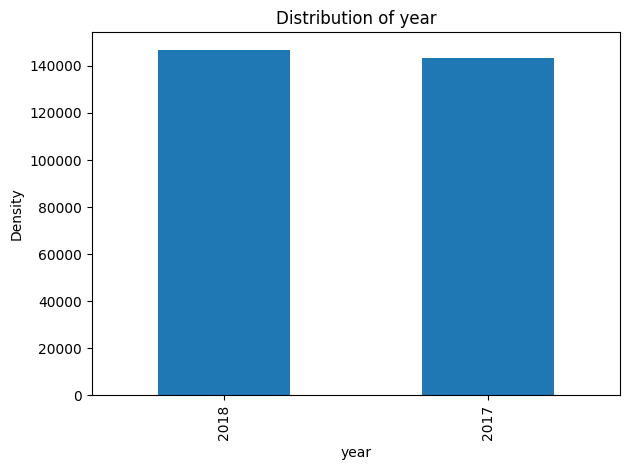

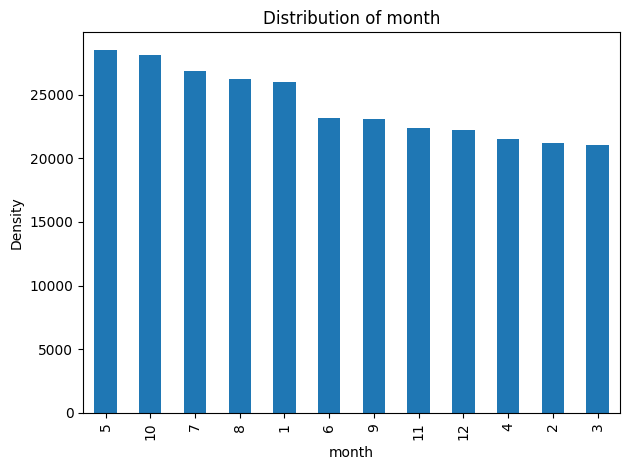

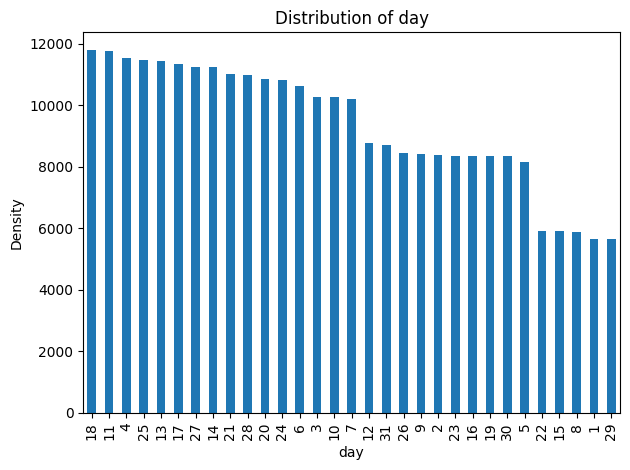

In [70]:
# Distribution of categorical variables
plt.figure(figsize=(10,40))
for col_name in categorical_column_list:
    plt.figure()
    drought_df_categorical[col_name].value_counts().plot(kind = 'bar')
    x_name = col_name
    y_name = 'Density'
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))
    plt.tight_layout()

####  Seperating Input and Output Variables for the Model

In [71]:
input_variables = drought_df.drop('score', axis=1)
input_variables = input_variables.drop('fips', axis=1)
input_variables.head()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,year,month,day
2,18.82,99.69,9.74,14.24,13.44,13.44,18.48,9.29,9.20,14.06,...,3.73,1.64,2.09,4.80,7.27,2.54,4.72,2017,1,3
9,0.02,101.13,5.62,5.92,4.54,4.55,12.42,-2.37,14.79,5.81,...,4.24,2.52,1.72,6.19,7.55,4.68,2.86,2017,1,10
16,0.14,100.60,11.41,17.21,16.06,16.06,23.03,13.15,9.88,17.10,...,3.61,1.71,1.90,4.93,5.90,2.76,3.15,2017,1,17
23,0.00,99.72,5.60,9.27,5.34,5.35,16.23,4.18,12.06,8.95,...,2.34,1.03,1.31,3.52,6.49,1.47,5.02,2017,1,24
30,0.00,100.37,7.31,11.38,9.21,9.21,20.29,5.05,15.24,11.32,...,3.00,1.76,1.24,5.00,7.40,2.88,4.52,2017,1,31


In [72]:
target = drought_df['score']
target.head()

2     2
9     2
16    2
23    1
30    1
Name: score, dtype: int32

### Correlation between independent variables for Feature Selection

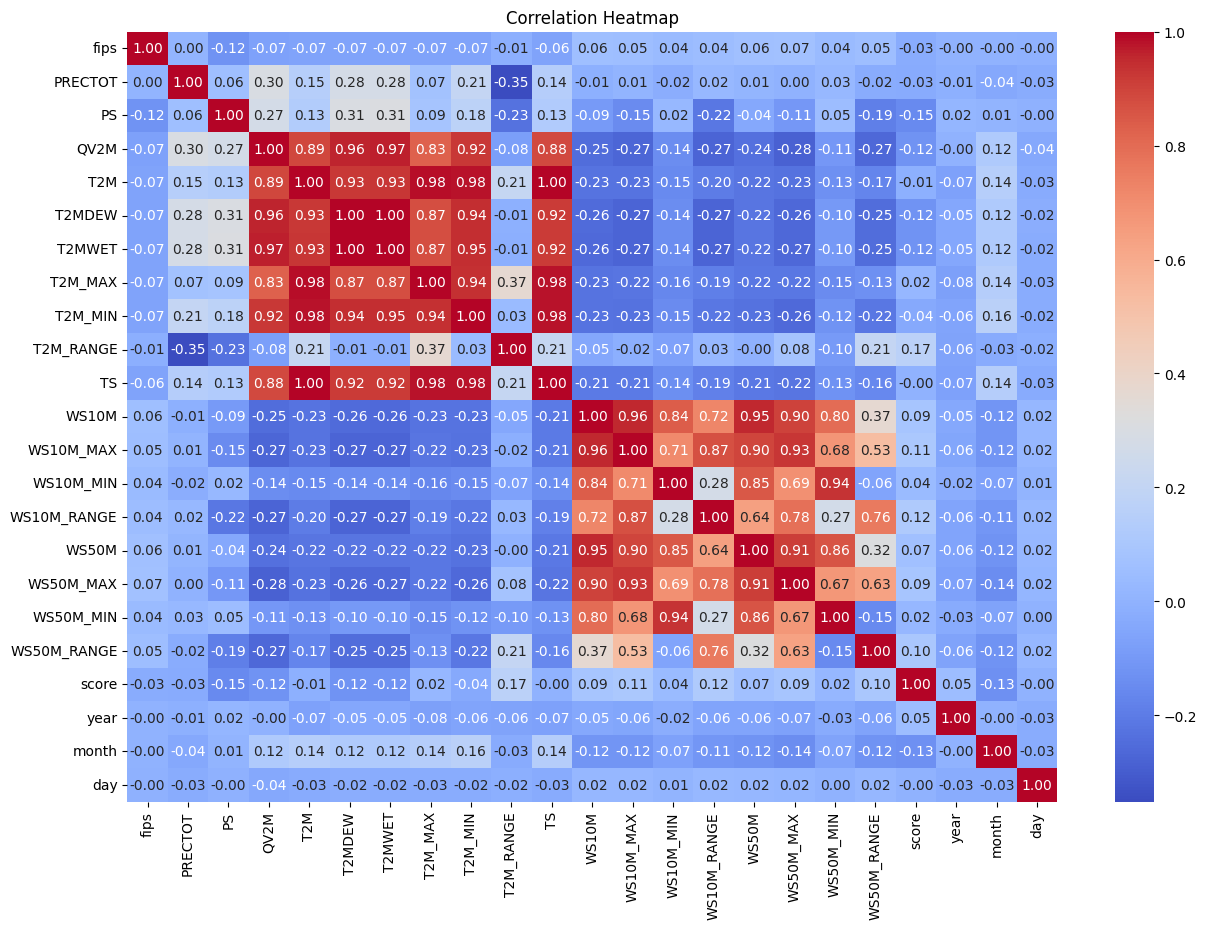

In [73]:
numeric_df = drought_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

#### <font color='darkgreen'>Attributes QV2M,	T2M,	T2MDEW,	T2MWET,	T2M_MAX,	T2M_MIN and TS have shown strong positive correlation

#### <font color='darkgreen'>Similary WS10M,	WS10M_MAX and	WS10M_MIN have shown a strong positve correlation

#### <font color='darkgreen'>Likewise, WS50M,	WS50M_MAX and	WS50M_MIN	show strong positive correlation

#### <font color='darkgreen'>However, from the scatter plots above, we see significant variance between the data points, despite the strong positive correlation. Hence we'll retain all these variables, and try other feature selection methods.

### Splitting into train and test

In [74]:
X_train, X_test, y_train, y_test = train_test_split(input_variables, target, test_size=0.2, random_state=0)

In [75]:
print("Train features shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test features shape", X_test.shape)
print("Test target shape", y_test.shape)

Train features shape (232206, 21)
Train target shape (232206,)
Test features shape (58052, 21)
Test target shape (58052,)


### Standardizing the data

In [76]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[ 0.39320915, -0.23841562,  0.77740784, ..., -1.012376  ,
         0.72283385, -1.2660919 ],
       [ 0.0981732 , -0.13989716, -1.09898169, ...,  0.98777529,
        -1.04074905,  0.45176428],
       [ 0.25282914,  0.8956923 ,  2.22845528, ...,  0.98777529,
         0.72283385,  0.22271679],
       ...,
       [-0.5228299 ,  0.24272107, -0.84255536, ...,  0.98777529,
        -0.74681857,  0.90985926],
       [-0.5228299 , -1.81012882, -0.94634697, ..., -1.012376  ,
        -1.04074905,  0.56628803],
       [-0.41100176,  0.22210093,  1.08267729, ...,  0.98777529,
         0.72283385,  0.22271679]])

In [77]:
print(input_variables.columns)

Index(['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
       'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 'year',
       'month', 'day'],
      dtype='object')


### Feature Selection using RFE and Random Forest algorithm

In [31]:
model = RandomForestClassifier(n_estimators=10) # n_estimators is the hyperparameter
rfe = RFE(model, n_features_to_select=15) # n_features_to_select is chosen on a trial and error basis
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
selected_features = input_variables.columns[(fit.get_support())]
print(selected_features)

Num Features: 15
Selected Features: [False  True  True  True  True  True  True  True  True  True False False
 False  True  True  True False  True False  True  True]
Feature Ranking: [4 1 1 1 1 1 1 1 1 1 5 2 6 1 1 1 3 1 7 1 1]
Index(['PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN',
       'T2M_RANGE', 'TS', 'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_RANGE',
       'month', 'day'],
      dtype='object')


#### Drop the columns that are not in the top 15 priority from the above analysis

In [78]:
input_variables = input_variables.drop('PRECTOT', axis=1)
input_variables =input_variables.drop('WS10M', axis=1)
input_variables = input_variables.drop('WS10M_MAX', axis=1)
input_variables = input_variables.drop('WS10M_MIN', axis=1)
input_variables = input_variables.drop('WS50M_MIN', axis=1)
input_variables = input_variables.drop('year', axis=1)
input_variables = input_variables.drop('month',axis=1)
input_variables = input_variables.drop('day',axis=1)

input_variables.head()

X_train, X_test, y_train, y_test = train_test_split(input_variables, target, test_size=0.2, random_state=0)

print("Train features shape", X_train.shape)
print("Train target shape", y_train.shape)
print("Test features shape", X_test.shape)
print("Test target shape", y_test.shape)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Train features shape (232206, 13)
Train target shape (232206,)
Test features shape (58052, 13)
Test target shape (58052,)


In [79]:
print(input_variables.dtypes)

PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_RANGE    float64
dtype: object


### Downsampling Data to improve effeciency

In [80]:
print(input_variables.head())

        PS   QV2M    T2M  T2MDEW  T2MWET  T2M_MAX  T2M_MIN  T2M_RANGE     TS  \
2    99.69   9.74  14.24   13.44   13.44    18.48     9.29       9.20  14.06   
9   101.13   5.62   5.92    4.54    4.55    12.42    -2.37      14.79   5.81   
16  100.60  11.41  17.21   16.06   16.06    23.03    13.15       9.88  17.10   
23   99.72   5.60   9.27    5.34    5.35    16.23     4.18      12.06   8.95   
30  100.37   7.31  11.38    9.21    9.21    20.29     5.05      15.24  11.32   

    WS10M_RANGE  WS50M  WS50M_MAX  WS50M_RANGE  
2          2.09   4.80       7.27         4.72  
9          1.72   6.19       7.55         2.86  
16         1.90   4.93       5.90         3.15  
23         1.31   3.52       6.49         5.02  
30         1.24   5.00       7.40         4.52  


#### Downsampling using Near Miss
##### Near Miss is an undersampling technique that selects examples from the majority class based on their distance to instances from the minority class. It works by keeping only those majority class samples that are closest to the minority class samples, essentially creating "near misses".

In [81]:
undersample = NearMiss()
X_train_dres_nm, y_train_dres_nm = undersample.fit_resample(X_train, y_train)

In [83]:
print('Before UnderSampling, the shape of train_X: {}'.format(X_train.shape))
print('Before UnderSampling, the shape of train_y: {} \n'.format(y_train.shape))

print('After UnderSampling, the shape of train_X: {}'.format(X_train_dres_nm.shape))
print('After UnderSampling, the shape of train_y: {} \n'.format(y_train_dres_nm.shape))

print("Counts of label '0' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 0),sum(y_train_dres_nm == 0)))
print("Counts of label '1' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 1),sum(y_train_dres_nm == 1)))
print("Counts of label '2' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 2),sum(y_train_dres_nm == 2)))
print("Counts of label '3' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 3),sum(y_train_dres_nm == 3)))
print("Counts of label '4' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 4),sum(y_train_dres_nm == 4)))
print("Counts of label '5' - Before UnderSampling:{}, After UnderSampling: {}".format(sum(y_train == 5),sum(y_train_dres_nm == 5)))

Before UnderSampling, the shape of train_X: (232206, 13)
Before UnderSampling, the shape of train_y: (232206,) 

After UnderSampling, the shape of train_X: (1932, 13)
After UnderSampling, the shape of train_y: (1932,) 

Counts of label '0' - Before UnderSampling:160270, After UnderSampling: 322
Counts of label '1' - Before UnderSampling:40424, After UnderSampling: 322
Counts of label '2' - Before UnderSampling:20283, After UnderSampling: 322
Counts of label '3' - Before UnderSampling:8266, After UnderSampling: 322
Counts of label '4' - Before UnderSampling:2641, After UnderSampling: 322
Counts of label '5' - Before UnderSampling:322, After UnderSampling: 322


### Model Development

#### Decision Tree Algorithm Downsampled Data

In [84]:
DT_classifier_NM = tree.DecisionTreeClassifier(criterion='gini')
DT_classifier_NM.fit(X_train_dres_nm,y_train_dres_nm)
y_pred_NM = DT_classifier_NM.predict(X_test)

In [85]:
pickle.dump(DT_classifier_NM, open('DT_classifier_NM.pkl', 'wb'))

In [86]:
print('Performance of Decision Tree Algorithm with Near Miss Downsampling:\n')
print(confusion_matrix(y_test, y_pred_NM))
print(classification_report(y_test, y_pred_NM))
print('Accuracy:',accuracy_score(y_test, y_pred_NM))
print('Precision:',precision_score(y_test, y_pred_NM, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_NM, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_NM, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_NM))

Performance of Decision Tree Algorithm with Near Miss Downsampling:

[[ 3801  9096  8036 11736  2760  4618]
 [  566  2431  2035  3010   853  1250]
 [  206  1117   859  1582   487   707]
 [   79   400   322   688   270   388]
 [   25    91    84   165   137   154]
 [    5     9     6    14    29    36]]
              precision    recall  f1-score   support

           0       0.81      0.09      0.17     40047
           1       0.18      0.24      0.21     10145
           2       0.08      0.17      0.11      4958
           3       0.04      0.32      0.07      2147
           4       0.03      0.21      0.05       656
           5       0.01      0.36      0.01        99

    accuracy                           0.14     58052
   macro avg       0.19      0.23      0.10     58052
weighted avg       0.60      0.14      0.17     58052

Accuracy: 0.13698063804864605
Precision: 0.6006598485372161
Recall: 0.13698063804864605
F1 Score: 0.16597399590357806
Cohen Kappa Score: 0.01488592166673

#### KNN Algorithm with downsampled Data

In [87]:
knn_classifier_NM = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
knn_classifier_NM.fit(X_train_dres_nm, y_train_dres_nm)
y_pred_knn_NM = knn_classifier_NM.predict(X_test)

In [88]:
pickle.dump(knn_classifier_NM, open('knn_classifier_NM.pkl', 'wb'))

In [89]:
print('Performance of KNN Algorithm with NM Downsampling:\n')
print(confusion_matrix(y_test, y_pred_knn_NM))
print(classification_report(y_test, y_pred_knn_NM))
print('Accuracy:',accuracy_score(y_test, y_pred_knn_NM))
print('Precision:',precision_score(y_test, y_pred_knn_NM, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_knn_NM, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_knn_NM, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_knn_NM))

Performance of KNN Algorithm with NM Downsampling:

[[2927 8192 8835 8079 3062 8952]
 [ 596 2009 2380 1974  899 2287]
 [ 211  905 1076 1058  485 1223]
 [  72  357  331  524  272  591]
 [  10   65   63  142  148  228]
 [   2    3    5    8   30   51]]
              precision    recall  f1-score   support

           0       0.77      0.07      0.13     40047
           1       0.17      0.20      0.19     10145
           2       0.08      0.22      0.12      4958
           3       0.04      0.24      0.08      2147
           4       0.03      0.23      0.05       656
           5       0.00      0.52      0.01        99

    accuracy                           0.12     58052
   macro avg       0.18      0.25      0.10     58052
weighted avg       0.57      0.12      0.14     58052

Accuracy: 0.1160166747054365
Precision: 0.5685401081438907
Recall: 0.1160166747054365
F1 Score: 0.13826945213704586
Cohen Kappa Score: 0.009425982318658876


#### Random Forest with Downsampled Data

In [90]:
rf_classifier_nm = RandomForestClassifier(n_estimators = 50, max_depth=80, bootstrap=False, max_features='sqrt', random_state=0)
rf_classifier_nm.fit(X_train_dres_nm, y_train_dres_nm)
y_pred_rf_nm = rf_classifier_nm.predict(X_test)

In [91]:
pickle.dump(rf_classifier_nm, open('svm_classifier_nm.pkl', 'wb'))

In [92]:
print('Performance of Random Forest Algorithm with Near Miss downsampling:\n')
print(confusion_matrix(y_test, y_pred_rf_nm))
print(classification_report(y_test, y_pred_rf_nm))
print('Accuracy:',accuracy_score(y_test, y_pred_rf_nm))
print('Precision:',precision_score(y_test, y_pred_rf_nm, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_rf_nm, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_rf_nm, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_rf_nm))

Performance of Random Forest Algorithm with Near Miss downsampling:

[[ 2862  5063  7658  9609  1315 13540]
 [  482  1340  1956  2406   533  3428]
 [  157   526   857  1260   289  1869]
 [   50   149   276   625   218   829]
 [    7    17    58   164   157   253]
 [    5     5     3     4    26    56]]
              precision    recall  f1-score   support

           0       0.80      0.07      0.13     40047
           1       0.19      0.13      0.16     10145
           2       0.08      0.17      0.11      4958
           3       0.04      0.29      0.08      2147
           4       0.06      0.24      0.10       656
           5       0.00      0.57      0.01        99

    accuracy                           0.10     58052
   macro avg       0.20      0.25      0.10     58052
weighted avg       0.60      0.10      0.13     58052

Accuracy: 0.10158134086680906
Precision: 0.596224905463116
Recall: 0.10158134086680906
F1 Score: 0.13096036317562543
Cohen Kappa Score: 0.013098003017537

#### Random Forest without resampling

In [93]:
RF_classifier = RandomForestClassifier(n_estimators = 50, max_depth=80, bootstrap=False, max_features='sqrt', random_state=0)
RF_classifier.fit(X_train, y_train)
y_pred_RF = RF_classifier.predict(X_test)

In [94]:
print('Performance of RF Algorithm without resampling - After Hyperparamter Tuning:\n')
print(confusion_matrix(y_test, y_pred_RF))
print(classification_report(y_test, y_pred_RF))
print('Accuracy:',accuracy_score(y_test, y_pred_RF))
print('Precision:',precision_score(y_test, y_pred_RF, average='weighted'))
print('Recall:',recall_score(y_test, y_pred_RF, average='weighted'))
print('F1 Score:',f1_score(y_test, y_pred_RF, average='weighted'))
print('Cohen Kappa Score:',cohen_kappa_score(y_test, y_pred_RF))

Performance of RF Algorithm without resampling - After Hyperparamter Tuning:

[[38443  1402   156    30    16     0]
 [ 4463  4879   751    45     7     0]
 [ 1496   984  2158   302    18     0]
 [  676   154   418   790   107     2]
 [  184    39    49   155   218    11]
 [   43     8     4    11    23    10]]
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     40047
           1       0.65      0.48      0.55     10145
           2       0.61      0.44      0.51      4958
           3       0.59      0.37      0.45      2147
           4       0.56      0.33      0.42       656
           5       0.43      0.10      0.16        99

    accuracy                           0.80     58052
   macro avg       0.62      0.45      0.50     58052
weighted avg       0.78      0.80      0.78     58052

Accuracy: 0.8009715427547716
Precision: 0.7806799308401968
Recall: 0.8009715427547716
F1 Score: 0.7834348199657796
Cohen Kappa Score: 0.54037734

In [95]:
# Save the model
filename = 'droughtfile.sav'
pickle.dump(rf_classifier_nm, open(filename, 'wb'))

In [47]:
# Load the model
loaded_model = pickle.load(open('droughtfile.sav', 'rb'))